## `Import Libraries`

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

# other
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive

## `Data Loading`

In [2]:
def load_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read image at {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

def preprocess_dataset(images, labels, target_size=(224, 224)):
    preprocessed_images = images.astype('float32') / 255.0
    normalized_labels = labels / np.array([target_size[1], target_size[0], target_size[1], target_size[0]])
    return preprocessed_images, normalized_labels

def load_dataset(image_dir, csv_path, target_size=(224, 224)):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(image_dir, row['filename'])
        image = load_image(img_path)
        if image is not None:
            # Resize gambar ke ukuran target
            image = cv2.resize(image, target_size)
            images.append(image)
            labels.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])

    images = np.array(images)
    labels = np.array(labels, dtype=np.float32)
    return preprocess_dataset(images, labels, target_size)


In [3]:
# mount Google Drive
drive.mount('/content/drive')

# Path ke folder images dan file CSV di Google Drive
# Sesuaikan jalur ini dengan struktur folder Anda di Google Drive
train_image_dir = '/content/drive/My Drive/data/train'
train_csv_path = '/content/drive/My Drive/data/train/_annotations.csv'

valid_image_dir = '/content/drive/My Drive/data/valid'
valid_csv_path = '/content/drive/My Drive/data/valid/_annotations.csv'

test_image_dir = '/content/drive/My Drive/data/test'
test_csv_path = '/content/drive/My Drive/data/test/_annotations.csv'

# Muat dataset
X_train, y_train = load_dataset(train_image_dir, train_csv_path)
X_val, y_val = load_dataset(valid_image_dir, valid_csv_path)
X_test, y_test = load_dataset(test_image_dir, test_csv_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## `Model Achitecture`

In [4]:
# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='linear')  # Output 4 koordinat bounding box
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 164484 (642.52 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [5]:
# Callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001)
checkpoint_path = "/content/drive/My Drive/Data"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mae', save_best_only=True,
                                    save_weights_only=False, mode='min')

## `Train Model`

In [6]:
# Train model
%%time
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Load model terbaik setelah training
model.load_weights(checkpoint_path)
model.save('/content/drive/My Drive/data/base_MobileNet.keras')

Epoch 1/100
55/55 [==============================] - 21s 215ms/step - loss: 0.5692 - mae: 0.5886 - val_loss: 0.3510 - val_mae: 0.4562 - lr: 0.0010
Epoch 2/100
55/55 [==============================] - 6s 108ms/step - loss: 0.4033 - mae: 0.4976 - val_loss: 0.3625 - val_mae: 0.4774 - lr: 0.0010
Epoch 3/100
55/55 [==============================] - 6s 114ms/step - loss: 0.3840 - mae: 0.4859 - val_loss: 0.4278 - val_mae: 0.5405 - lr: 0.0010
Epoch 4/100
55/55 [==============================] - 7s 131ms/step - loss: 0.4058 - mae: 0.5045 - val_loss: 0.3801 - val_mae: 0.5004 - lr: 0.0010
Epoch 5/100
55/55 [==============================] - 7s 136ms/step - loss: 0.3869 - mae: 0.4866 - val_loss: 0.3610 - val_mae: 0.4744 - lr: 0.0010
Epoch 6/100
55/55 [==============================] - 7s 131ms/step - loss: 0.3977 - mae: 0.4924 - val_loss: 0.3564 - val_mae: 0.4690 - lr: 0.0010
Epoch 7/100
55/55 [==============================] - 8s 138ms/step - loss: 0.3681 - mae: 0.4724 - val_loss: 0.3610 - val_ma

## `Evaluasi Model`

In [7]:
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1p, y1p, x2p, y2p = box2

    xi1 = max(x1, x1p)
    yi1 = max(y1, y1p)
    xi2 = min(x2, x2p)
    yi2 = min(y2, y2p)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2p - x1p) * (y2p - y1p)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def calculate_map(y_true, y_pred, iou_threshold=0.5):
    precisions = []
    recalls = []
    for threshold in np.arange(0.5, 1.0, 0.05):
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(y_true)):
            iou = calculate_iou(y_true[i], y_pred[i])
            if iou >= threshold:
                tp += 1
            else:
                fp += 1
                fn += 1
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

# Prediksi menggunakan model
y_pred = model.predict(X_val)

# Hitung IoU
ious = [calculate_iou(y_val[i], y_pred[i]) for i in range(len(y_val))]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

# Hitung mAP
precision, recall = calculate_map(y_val, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

17/17 [==============================] - 2s 79ms/step
Mean IoU: 0.0481
Precision: 0.0008
Recall: 0.0008


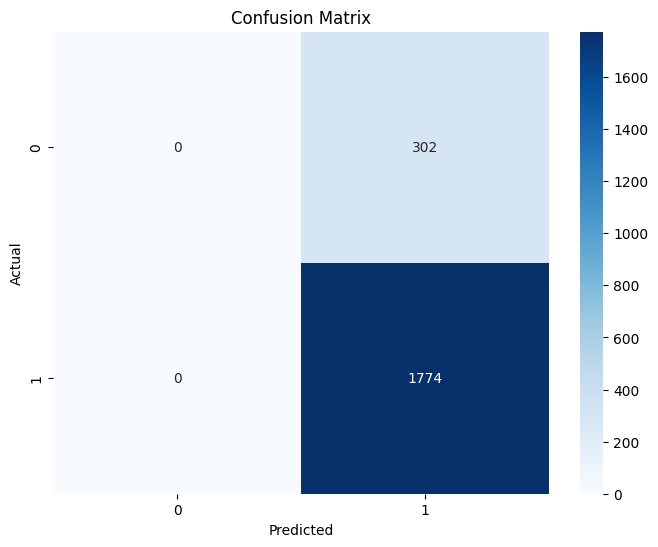

In [8]:
# Plot Confusion Matrix
y_true_classes = (y_val > 0.5).astype(int).flatten()
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

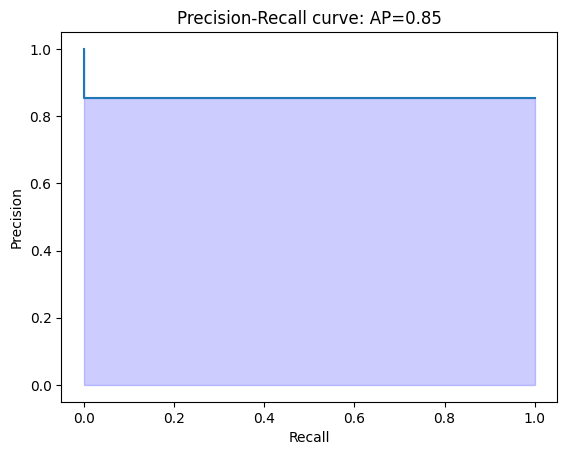

In [9]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_classes)
average_precision = average_precision_score(y_true_classes, y_pred_classes)

plt.figure()
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()

## `Hyperparameter Tuning`

In [ ]:
%%time
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
optimizers = ['adam', 'sgd']

best_accuracy = 0
best_params = {}

def create_model(learning_rate):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(4, activation='linear')
    ])
    return model

for optimizer_name in optimizers:
    for lr in learning_rates:
        for bs in batch_sizes:
            if optimizer_name == 'adam':
                optimizer = Adam(learning_rate=lr)
            elif optimizer_name == 'sgd':
                optimizer = SGD(learning_rate=lr)

            model = create_model(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

            history = model.fit(
                X_train, y_train,
                epochs=20,
                batch_size=bs,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )

            val_accuracy = history.history['val_mae'][-1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'optimizer': optimizer_name, 'learning_rate': lr, 'batch_size': bs}

print("Best parameters:", best_params)
print("Best validation accuracy:", best_accuracy)

## `Retrain with Best Parameter`

In [ ]:
# Retrain model with best parameters
if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    optimizer = SGD(learning_rate=best_params['learning_rate'])

final_model = create_model(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

final_history = final_model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Load model terbaik setelah training
final_model.load_weights(checkpoint_path)
final_model.save('/content/drive/My Drive/data/tuned_MobileNet.keras')


## `Evaluate Final Model`

In [ ]:
# Hitung IoU
ious = [calculate_iou(y_val[i], y_pred[i]) for i in range(len(y_val))]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

# Hitung mAP
precision, recall = calculate_map(y_val, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

In [ ]:
# Plot Confusion Matrix
y_true_classes = (y_val > 0.5).astype(int).flatten()
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_classes)
average_precision = average_precision_score(y_true_classes, y_pred_classes)

plt.figure()
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()
